## Example integrated analysis of seqFISH data and force inference & morphometrics for mouse E8.5 embryo dorsal region

Import required modules

In [1]:
import matplotlib.colors
import numpy as np
import matplotlib.pyplot as plt
import skimage
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler
import seaborn as sns
import umap
import scanpy as sc
import os

First, import data;`vmsi_res` contains the force inference and morhpometrics results, `gex` contains
the normalised and log-transformed expression values derived from seqFISH, and `neighbours` is a cell-cell adjacency graph
where non-zero values denote junctions between cells and the value denotes the tension at that junction.

Note: cells in the `vmsi_res` do not correspond exactly to the force inference output from `mouse_dorsal_seqfish_inferece.ipynb`
as some cells were filtered out to maintain consistency with seqFISH data.

In [2]:
curr_wd = os.getcwd()

gex = pd.read_csv(f'{curr_wd}/../example_data/mouse_dorsal_seqFISH/gex.csv', index_col=0)
neighbours = pd.read_csv(f'{curr_wd}/../example_data/mouse_dorsal_seqFISH/neighbours.csv', index_col=0)
vmsi_res = pd.read_csv(f'{curr_wd}/../example_data/mouse_dorsal_seqFISH/vmsi_res_merged.csv', index_col=0)

#### Integrated clustering with MUSE

Now that we have both force inferece/morphometrics and gene expression, we would like to see if
combining these modalities results in different celltype annotations compared to annotations from gene
expression alone.

We can do this using MUSE (*Bao el al., 2022*) to combine these modalities into a single joint latent representation
from which clusters can be obtained.

MUSE requires initial cluster labels for both modalities as input for the NN. We derive these from `phenograph`,
which is less sensitive to hyperparameter values.

To perform clustering, we first perform PCA on both modalities separately.

In [3]:
gex_norm = StandardScaler().fit_transform(gex.T)
pca = PCA()
gex_pca = pca.fit_transform(gex_norm)

vmsi_res_norm = StandardScaler().fit_transform(vmsi_res.drop(['centroid_x','centroid_y','celltype','celltype_conf'], axis=1))
pca = PCA()
vmsi_pca = pca.fit_transform(vmsi_res_norm)

Then, we obtain cluster labels with `phenograph`.

In [4]:
import phenograph

# assign initial cluster labels to morphometric data using phenograph
vmsi_labels,_,_ = phenograph.cluster(vmsi_pca)
# use gex clusters from Nat Biotech as initial cluster labels
#gex_labels = gex_metadata['cluster'].values
gex_labels,_,_ = phenograph.cluster(gex_pca)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.1392230987548828 seconds
Jaccard graph constructed in 1.704286813735962 seconds
Wrote graph to binary file in 0.22783493995666504 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.670366
After 2 runs, maximum modularity is Q = 0.67498
Louvain completed 22 runs in 0.9897463321685791 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 4.054747104644775 seconds
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.22325396537780762 seconds
Jaccard graph constructed in 1.7025389671325684 seconds
Wrote graph to binary file in 0.2821788787841797 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.77991
Louvain completed 21 runs in 0.8288912773132324 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 4.078504800796509 seconds


Finally, run MUSE:

In [5]:
import muse_sc as muse

muse_features, reconstruct_x, reconstruct_y, latent_x, latent_y = muse.muse_fit_predict(vmsi_res_norm, gex_norm,
                                                                                        vmsi_labels, gex_labels,
                                                                                        latent_dim=100, n_epochs=500,
                                                                                        lambda_regul=5, lambda_super=5)

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Use `tf.cast` instead.
++++++++++ MUSE for multi-modality single-cell analysis ++++++++++
MUSE initialization


2022-07-29 05:28:52.447304: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


epoch: 0, 	 total loss: 9293.27148,	 reconstruction loss: 8292.68848,	 sparse penalty: 200.11658
epoch: 50, 	 total loss: 6187.27588,	 reconstruction loss: 5270.65576,	 sparse penalty: 183.32401
epoch: 100, 	 total loss: 5945.94580,	 reconstruction loss: 5117.31689,	 sparse penalty: 165.72580
epoch: 150, 	 total loss: 5747.33789,	 reconstruction loss: 5003.75781,	 sparse penalty: 148.71600
epoch: 0, 	 total loss: 5676.18018,	 reconstruction loss: 4912.72656,	 sparse penalty: 132.65450,	 x triplet: 11.86179,	 y triplet: 8.17443
epoch: 50, 	 total loss: 5491.71680,	 reconstruction loss: 4832.50293,	 sparse penalty: 117.85619,	 x triplet: 8.63594,	 y triplet: 5.35066
epoch: 100, 	 total loss: 5359.01758,	 reconstruction loss: 4773.22900,	 sparse penalty: 103.80795,	 x triplet: 8.37445,	 y triplet: 4.97540
epoch: 150, 	 total loss: 5240.79541,	 reconstruction loss: 4722.05566,	 sparse penalty: 90.71474,	 x triplet: 8.24241,	 y triplet: 4.79084
Finding 30 nearest neighbors using minkowski m

We can re-cluster with phenograph to obtain new clusters from the joint features computed by MUSE:

In [6]:
# Cluster on MUSE features
muse_labels,_,_ = phenograph.cluster(muse_features)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.22519707679748535 seconds
Jaccard graph constructed in 1.641679048538208 seconds
Wrote graph to binary file in 0.07300901412963867 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.89963
Louvain completed 21 runs in 0.8106660842895508 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 3.7189600467681885 seconds


Compare these MUSE-derived clusters with the original gene expression-derived celltypes:

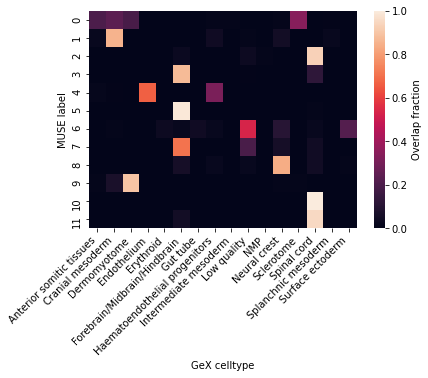

In [9]:
vmsi_res['muse_labels'] = muse_labels

cm = pd.DataFrame(np.zeros((len(np.unique(vmsi_res['muse_labels'])), len(np.unique(vmsi_res['celltype'].values)))))
cm.index = np.unique(vmsi_res['muse_labels'])
cm.columns = np.unique(vmsi_res['celltype'].values)

for i in range(len(vmsi_res['muse_labels'])):
    cm.loc[vmsi_res['muse_labels'].values[i], vmsi_res['celltype'].values[i]] += 1
cm = cm.divide(cm.sum(axis=1), axis=0)

g = sns.heatmap(cm, cbar_kws={'label': 'Overlap fraction'})
g.set(xlabel='GeX celltype', ylabel='MUSE label')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()